# Chapter 4 - Estimating proportions
http://allendowney.github.io/ThinkBayes2/chap04.html

## Reading

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params
set_pyplot_params()

### The Euro problem and the binomial distribution

In [3]:
from scipy.stats import binom

n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

This is the probability of getting $k=1$ heads from flipping a coin $n=2$ times with probability of heads $p=0.5$.

In [4]:
import numpy as np
ks = np.arange(n+1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [5]:
from empiricaldist import Pmf

pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [7]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [8]:
pmf_k = make_binomial(n=250, p=0.5)

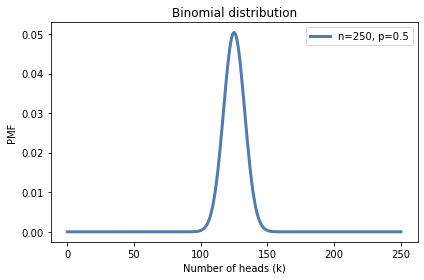

In [9]:
from utils import decorate

pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [10]:
pmf_k.max_prob()

125

In [11]:
pmf_k[125]

0.050412213147309655

In [12]:
pmf_k[140]

0.008357181724918204

In [13]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

In [14]:
prob_ge(pmf_k, 140)

0.03321057562002163

In [15]:
pmf_k.prob_ge(140)

0.03321057562002163

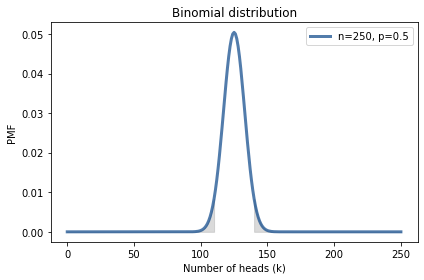

In [16]:
import matplotlib.pyplot as plt

def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [17]:
pmf_k.prob_le(110)

0.03321057562002164

### Bayesian estimation

In [18]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

In [19]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [20]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

In [21]:
dataset = 'H' * 140 + 'T' * 110
dataset

'HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT'

In [22]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [23]:
posterior = prior.copy()
update_euro(posterior, dataset)

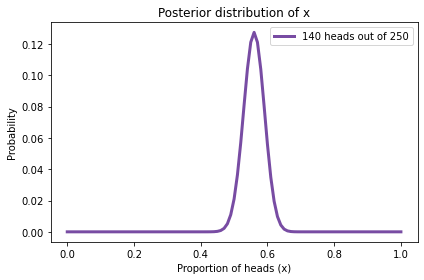

In [24]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

In [25]:
posterior.max_prob()

0.56

In [26]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

In [27]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

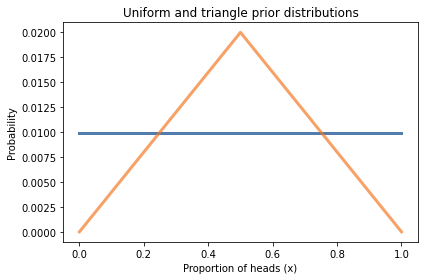

In [28]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

In [29]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

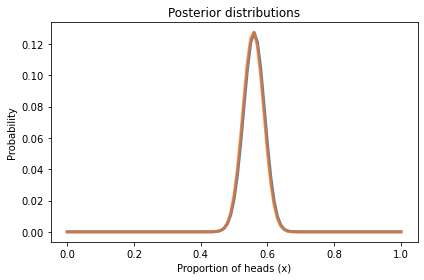

In [30]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

The priors are swamped, i.e. with enough data, starting with different priors will tend to converge on the same posterior distribution.

### The binomial likelihood function

In [31]:
def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [32]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

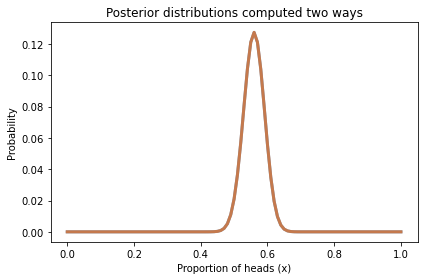

In [33]:
uniform.plot()
uniform2.plot()
decorate_euro(title='Posterior distributions computed two ways')

In [34]:
np.allclose(uniform, uniform2)

True

## Exercises

**Exercise:** In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts.  What is the posterior distribution for their probability of getting a hit?

In [36]:
# Start with uniform prior
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

In [37]:
likelihood = {
    'Y': hypos,
    'N': 1-hypos
}

In [38]:
# Author's dataset that yields reasonable prior
dataset = 'Y' * 25 + 'N' * 75

# Update prior
for data in dataset:
    prior *= likelihood[data]
    
prior.normalize()

1.3596964206970507e-23

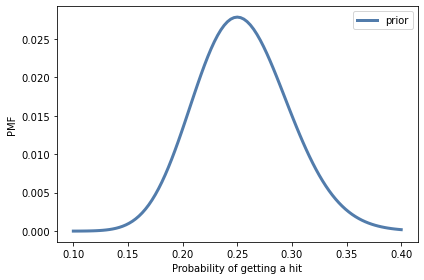

In [39]:
prior.plot(label='prior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF')

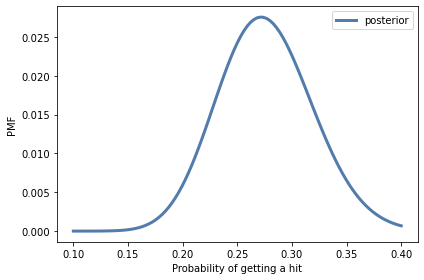

In [42]:
# Rookie dataset - 3 out of 3 hits
pmf = prior.copy()
dataset = 'YYY'
for data in dataset:
    pmf *= likelihood[data]
    
pmf.normalize()
    
pmf.plot(label='posterior')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF')

In [43]:
pmf.max_prob()

0.271

**Exercise:** Whenever you survey people about sensitive issues, you have to deal with [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias), which is the tendency of people to adjust their answers to show themselves in the most positive light.
One way to improve the accuracy of the results is [randomized response](https://en.wikipedia.org/wiki/Randomized_response).

As an example, suppose you want to know how many people cheat on their taxes.
If you ask them directly, it is likely that some of the cheaters will lie.
You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

* If they get heads, they report YES.

* If they get tails, they honestly answer the question "Do you cheat on your taxes?"

If someone says YES, we don't know whether they actually cheat on their taxes; they might have flipped heads.
Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs.  Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes?  What is the most likely quantity in the posterior distribution?

In [55]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
prior.normalize()

101

In [64]:
likelihood_yes = 1/2 * hypos + 1/2
likelihood_no = 1/2 * (1 - hypos)

likelihood = {'Y': likelihood_yes, 'N': likelihood_no}

In [65]:
dataset = 'Y' * 80 + 'N' * 20

In [66]:
pmf = prior.copy()

for data in dataset:
    pmf *= likelihood[data]
    
pmf.normalize()

3.657934567719507e-23

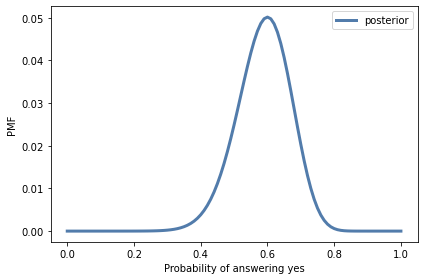

In [67]:
pmf.plot(label='posterior')
decorate(xlabel='Probability of answering yes',
         ylabel='PMF')

In [68]:
pmf.max_prob()

0.6

**Exercise:** Suppose you want to test whether a coin is fair, but you don't want to spin it hundreds of times.
So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate.  Specifically, suppose the probability is `y=0.2` that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of `x`?
What happens as you vary the value of `y`?

In [81]:
y = 0.2

In [69]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)
prior.normalize()

101

In [82]:
likelihood_h = (1 - y) * hypos + y * (1 - hypos)
likelihood_t = (1 - y) * (1 - hypos) + y * hypos

In [83]:
likelihood = {'H': likelihood_h, 'T': likelihood_t}

In [84]:
dataset = 'H' * 140 + 'T' * (250 - 140)

In [85]:
pmf = prior.copy()

for data in dataset:
    pmf *= likelihood[data]
    
pmf.normalize()

4.348053633122833e-76

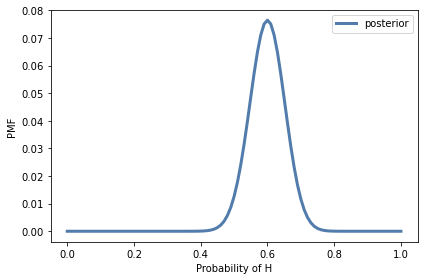

In [86]:
pmf.plot(label='posterior')
decorate(xlabel='Probability of H',
         ylabel='PMF')

In [87]:
def dist_H(y, prior, dataset):
    likelihood_h = (1 - y) * hypos + y * (1 - hypos)
    likelihood_t = (1 - y) * (1 - hypos) + y * hypos
    likelihood = {'H': likelihood_h, 'T': likelihood_t}
    
    pmf = prior.copy()
    for data in dataset:
        pmf *= likelihood[data]
    pmf.normalize()
    
    return pmf

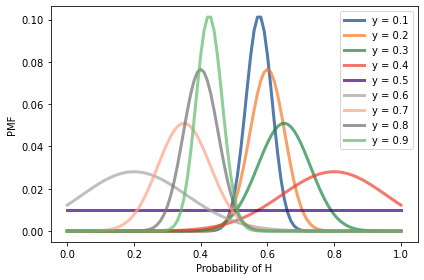

In [90]:
ys = np.linspace(0.1, 0.9, 9)
for y in ys:
    pmf = dist_H(y, prior, dataset)
    pmf.plot(label=f'y = {y:0.1f}')
    
decorate(xlabel='Probability of H', ylabel='PMF')

**Exercise:** In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is approximately uniform between 0.1 and 0.4.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad? 
That is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Hint: If the probability of hitting each target is $x$, the probability of hitting one target in both tests
is $\left[2x(1-x)\right]^2$.

In [91]:
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)
prior.normalize()

101

In [126]:
likelihood_single_test = {
    0: (1-hypos)**2,
    1: 2 * hypos * (1-hypos),
    2: hypos**2,
}

<AxesSubplot:>

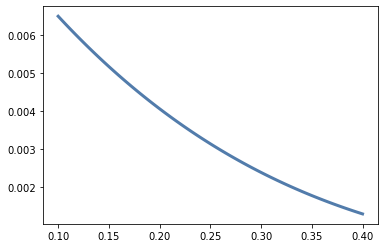

In [127]:
# 0, 0
pmf0 = prior.copy()
pmf0 *= likelihood_single_test[0]**2
# pmf0.normalize()
pmf0.plot()

In [128]:
pmf0.max_prob()

0.1

<AxesSubplot:>

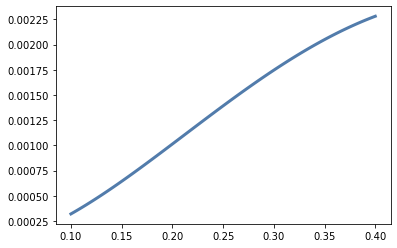

In [129]:
# 1, 1
pmf1 = prior.copy()
pmf1 *= likelihood_single_test[1]**2
# pmf1.normalize()
pmf1.plot()

In [130]:
pmf1.max_prob()

0.4

<AxesSubplot:>

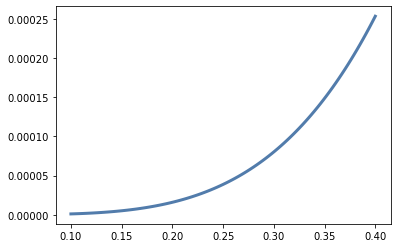

In [131]:
# 2, 2
pmf2 = prior.copy()
pmf2 *= likelihood_single_test[2]**2
# pmf2.normalize()
pmf2.plot()

In [133]:
pmf2.max_prob()

0.4

<AxesSubplot:>

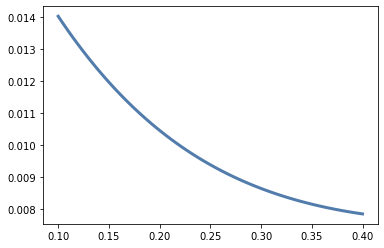

In [134]:
pmf = pmf0 + pmf1 + pmf2
pmf.normalize()
pmf.plot()

In [135]:
pmf.max_prob()

0.1